## Visualizing electron trajectories in a stack of two materials. Used for understanding the interaction between the electron beam in a scanning electron microscope (SEM) and the specimen under study.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import os
import csv

In [2]:
#Getting data file paths
filelist = []
for root,dirs,files in os.walk(os.getcwd()):
    for names in files:
        if 'kV.dat' in names:
              filelist.append(os.path.join(root,names))
filelist

['/Users/mofo/Google Drive/Python/Scientific Visualization/data/hBN_100nm_Si_10kV.dat',
 '/Users/mofo/Google Drive/Python/Scientific Visualization/data/hBN_100nm_Si_2kV.dat',
 '/Users/mofo/Google Drive/Python/Scientific Visualization/data/hBN_100nm_Si_5kV.dat']

In [6]:
#Opening a single data file and parsing to extract pertinent information
#First making a mask to get only the values we want
thefile = filelist[2]
mask = []
file = open(thefile)
for line in file:
    if '-------' in line:
        mask.append('stop')
    elif line == 'X\tY\tZ\tRx\tRy\tRz\tEnergy\tRegion\n':
        mask.append('start')
    else:
        mask.append('data')
mask = np.array(mask)
start = mask == 'start'
stop = mask == 'stop'

#makes a set of instructions of where to start and stop extracting data 
file = open(thefile)
lines = file.readlines()
start_locs = []
for a in range(len(lines)):
    if start[a]:
        start_locs.append(a)
start_locs = np.array(start_locs)        
stop_locs = []
for a in range(len(lines)):
    if stop[a]:
        stop_locs.append(a)
stop_locs = np.array(stop_locs)[1:]        

#extracts the lines we are interested in
trajecs_raw = []
for a,b in zip(start_locs,stop_locs):
    trajecs_raw.append(lines[a+1:b])

#extracting the actual values we are interested in and cleaning up data types 
trajecs = []
for t in trajecs_raw:
    temp = []
    for entry in t:
        new = entry.split('\t')
        temp.append([float(new[0]),float(new[1]),float(new[2]),float(new[6])])
        #X,Y,Z,Energy
    trajecs.append(np.array(temp))
    
#The output, trajecs, is a list of arrays. Each list item is the trajectory of a single electron.
#The first 3 columns of thearray entries are the X,Y, and Z coordinate of each scattering event.
#The last column is the electron energy after the scattering event

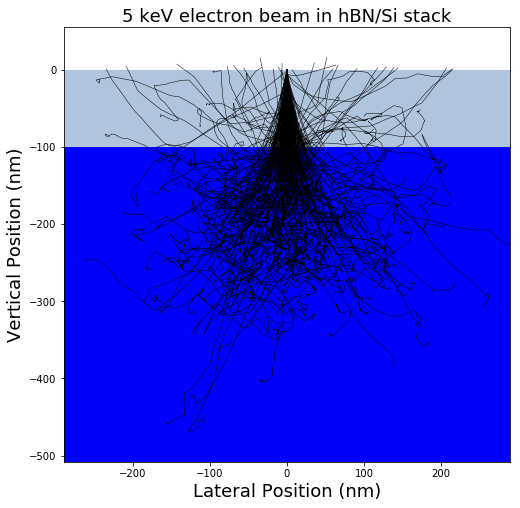

In [9]:
#quick and easy visualization. Each electron trajectory is represented as a black line

fig,ax = plt.subplots(1,1,figsize=(8,8))

for t in trajecs:
    ax.plot(t[:,0],-t[:,2],color='k',linewidth=0.5)
ax.axis('equal')

xlims = plt.xlim()
xlims = min([abs(x) for x in xlims])
xlims = (-xlims,xlims)
ylims = plt.ylim()

sample = Rectangle((-1000,-100),2000,100,color='lightsteelblue')
ax.add_patch(sample)
sub = Rectangle((-1000,-5000),2000,4900,color='blue')
ax.add_patch(sub)
ax.set_ylim(ylims)
ax.set_xlim(xlims)

ax.set_xlabel('Lateral Position (nm)',fontsize=18)
ax.set_ylabel('Vertical Position (nm)',fontsize=18)
ax.set_title('5 keV electron beam in hBN/Si stack',fontsize=18)

plt.show()

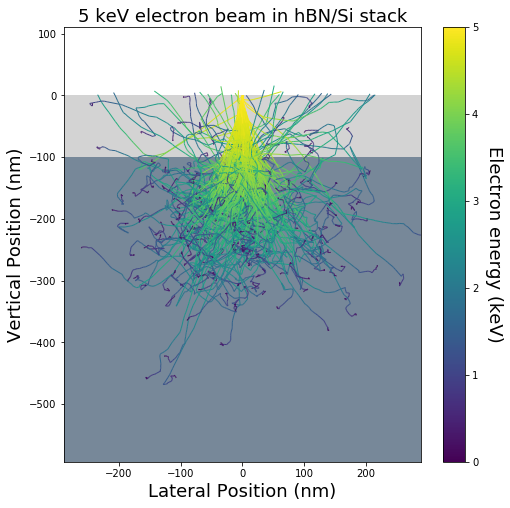

In [21]:
#More complicated and informative visualization. Now the lines are given a color scale to show the spatial 
#distribution of energy loss in the specimen.

max_energy = 5 #contrast limit

fig,ax = plt.subplots(1,1,figsize=(8,8))

norm = plt.Normalize(0,max_energy)

for t in trajecs[:]:
    ax.plot(t[:,0],-t[:,2],linewidth=0)
    
    energies = t[:,-1]
    
    points = np.array([t[:,0],-t[:,2]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap='viridis', norm=norm)

    lc.set_array(energies)
    lc.set_linewidth(1)
    line = ax.add_collection(lc)
    
ax.axis('equal')

xlims = plt.xlim()
xlims = min([abs(x) for x in xlims])
xlims = (-xlims,xlims)
ylims = plt.ylim()

cbar = fig.colorbar(line,ax=ax)
cbar.set_label('Electron energy (keV)', rotation=270,fontsize=18,labelpad=25)

sample = Rectangle((-1000,-100),2000,100,color='lightgrey')
ax.add_patch(sample)
sub = Rectangle((-1000,-5000),2000,4900,color='lightslategrey')
ax.add_patch(sub)
ax.set_ylim(ylims[0],top=10)
ax.set_xlim(xlims)

ax.set_xlabel('Lateral Position (nm)',fontsize=18)
ax.set_ylabel('Vertical Position (nm)',fontsize=18)
ax.set_title('5 keV electron beam in hBN/Si stack',fontsize=18)

#plt.tight_layout()
plt.show()

In [22]:
#Now extracting the data from all files in the same way as before
all_data = []
for thefile in filelist:

    mask = []
    file = open(thefile)
    for line in file:
        if '-------' in line:
            mask.append('stop')
        elif line == 'X\tY\tZ\tRx\tRy\tRz\tEnergy\tRegion\n':
            mask.append('start')
        else:
            mask.append('data')
    mask = np.array(mask)

    start = mask == 'start'
    stop = mask == 'stop'

    file = open(thefile)
    lines = file.readlines()

    start_locs = []
    for a in range(len(lines)):
        if start[a]:
            start_locs.append(a)
    start_locs = np.array(start_locs)

    stop_locs = []
    for a in range(len(lines)):
        if stop[a]:
            stop_locs.append(a)
    stop_locs = np.array(stop_locs)[1:]        

    trajecs_raw = []
    for a,b in zip(start_locs,stop_locs):
        trajecs_raw.append(lines[a+1:b])

    trajecs = []
    for t in trajecs_raw:
        temp = []
        for entry in t:
            new = entry.split('\t')
            temp.append([float(new[0]),float(new[1]),float(new[2]),float(new[6])])
            #X,Y,Z,Energy
        trajecs.append(np.array(temp))
    
    all_data.append(trajecs)

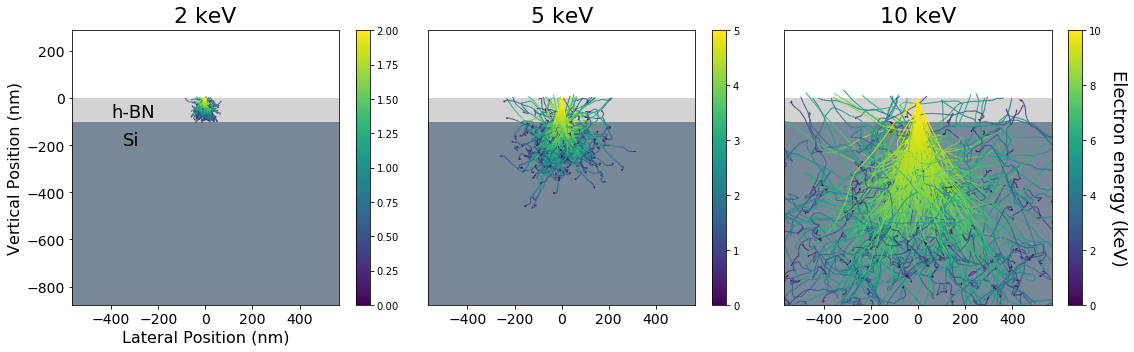

In [39]:
#putting together the visualizations from all 3 files to compare behavior between different beam energies

kev_list = [2,5,10]
#reordering the data for convenience
data_shuff = [all_data[1],all_data[2],all_data[0]]

fig,ax = plt.subplots(1,3,figsize = (16,5))
for a,b,c in zip(ax,data_shuff,kev_list):
    norm = plt.Normalize(0,c)
    for t in b[:]:
        a.plot(t[:,0],-t[:,2],linewidth=0)
    
        energies = t[:,-1]
    
        points = np.array([t[:,0],-t[:,2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
        lc = LineCollection(segments, cmap='viridis', norm=norm)

        lc.set_array(energies)
        lc.set_linewidth(1)
        line = a.add_collection(lc)
    
    a.axis('equal')
    title = str(c) + ' keV'
    a.set_title(title,fontsize=22,pad=8)
    cbar = fig.colorbar(line,ax=a)

    sample = Rectangle((-1000,-100),2000,100,color='lightgrey')
    a.add_patch(sample)
    sub = Rectangle((-1000,-5000),2000,4900,color='lightslategrey')
    a.add_patch(sub)
    
    a.set_ylim(-600,10)
    a.set_xlim(-450,450)

ax[0].text(-400,-80,'h-BN',fontsize=18)
ax[0].text(-350,-200,'Si',fontsize=18)

ax[1].set_yticks([])
ax[2].set_yticks([])

ax[0].set_xlabel('Lateral Position (nm)',fontsize=16)
ax[0].set_ylabel('Vertical Position (nm)',fontsize=16)

cbar.set_label('Electron energy (keV)', rotation=270,fontsize=18,labelpad=25)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()